In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import causaldata
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import linearmodels as lm
import causalpy as cp
from statsmodels.formula.api import ols
from sklearn import linear_model      

import pymc3 as pm
import numpy as np


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\Users\lukas\miniconda3\envs\bayesian-regression-env\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an em

In [ ]:
data = pd.read_csv(r'C:\Users\lukas\Documents\projects\Bayesian_regression\ilc_mded01_linear.csv')



In [10]:
import pandas as pd

# Load the dataset (assuming it's already loaded as 'data')

# Step 1: Cleaning and selecting relevant columns
df_clean = data[['hhtyp', 'incgrp', 'geo', 'TIME_PERIOD', 'OBS_VALUE']].dropna()

# Step 2: Encoding categorical variables using the mappings created earlier
hhtyp_mapping_descriptive = {
    'A1': 'One person household',
    'A1F': 'One female household',
    'A1M': 'One male household',
    'A1_DCH': 'One person household with dependent children',
    'A1_GE65': 'One person household aged 65+',
    'A1_LT65': 'One person household aged less than 65',
    'A2': 'Two person household',
    'A2_1DCH': 'Two person household with one dependent child',
    'A2_2DCH': 'Two person household with two dependent children',
    'A2_2LT65': 'Two person household aged less than 65',
    'A2_GE1_GE65': 'Two person household aged 65+',
    'A2_GE3DCH': 'Two person household with three or more dependent children',
    'A_GE3': 'Household with three or more adults',
    'A_GE3_DCH': 'Household with three or more adults with dependent children',
    'HH_DCH': 'Household with dependent children',
    'HH_NDCH': 'Household without dependent children',
    'TOTAL': 'Total households'
}

incgrp_mapping_descriptive = {
    'A_MD60': 'Below 60% of median income',
    'B_MD60': 'Above 60% of median income',
    'TOTAL': 'All income groups'
}

geo_mapping_descriptive = {
    'AL': 'Albania',
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'CH': 'Switzerland',
    'CY': 'Cyprus',
    'CZ': 'Czechia',
    'DE': 'Germany',
    'DK': 'Denmark',
    'EA': 'Euro area (19 countries)',
    'EA18': 'Euro area (18 countries)',
    'EA19': 'Euro area (19 countries)',
    'EA20': 'Euro area (20 countries)',
    'EE': 'Estonia',
    'EL': 'Greece',
    'ES': 'Spain',
    'EU': 'European Union (27 countries)',
    'EU27_2007': 'European Union (27 countries - 2007)',
    'EU27_2020': 'European Union (27 countries - 2020)',
    'EU28': 'European Union (28 countries)',
    'FI': 'Finland',
    'FR': 'France',
    'HR': 'Croatia',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IS': 'Iceland',
    'IT': 'Italy',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'LV': 'Latvia',
    'ME': 'Montenegro',
    'MK': 'North Macedonia',
    'MT': 'Malta',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'RS': 'Serbia',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'SK': 'Slovakia',
    'TR': 'Turkey',
    'UK': 'United Kingdom',
    'XK': 'Kosovo'
}

df_clean['hhtyp_encoded'] = df_clean['hhtyp'].map(hhtyp_mapping_descriptive)
df_clean['incgrp_encoded'] = df_clean['incgrp'].map(incgrp_mapping_descriptive)
df_clean['geo_encoded'] = df_clean['geo'].map(geo_mapping_descriptive)

# Step 3: Normalize numerical variables (TIME_PERIOD and OBS_VALUE)
df_clean['TIME_PERIOD_normalized'] = (df_clean['TIME_PERIOD'] - df_clean['TIME_PERIOD'].mean()) / df_clean['TIME_PERIOD'].std()
df_clean['OBS_VALUE_normalized'] = (df_clean['OBS_VALUE'] - df_clean['OBS_VALUE'].mean()) / df_clean['OBS_VALUE'].std()

# Step 4: Prepare the dataset for Bayesian regression
# Selecting the features and target
X = df_clean[['hhtyp_encoded', 'incgrp_encoded', 'geo_encoded', 'TIME_PERIOD_normalized']]
y = df_clean['OBS_VALUE_normalized']

# Display the cleaned and prepared data
df_clean.head()


,hhtyp,incgrp,geo,TIME_PERIOD,OBS_VALUE,hhtyp_encoded,incgrp_encoded,geo_encoded,TIME_PERIOD_normalized,OBS_VALUE_normalized
0,A1,A_MD60,AL,2017,24.3,One person household,Below 60% of median income,Albania,0.554980,-0.245863
1,A1,A_MD60,AL,2018,18.5,One person household,Below 60% of median income,Albania,0.741944,-0.683680
2,A1,A_MD60,AL,2019,19.8,One person household,Below 60% of median income,Albania,0.928907,-0.585549
3,A1,A_MD60,AL,2020,19.7,One person household,Below 60% of median income,Albania,1.115871,-0.593097
4,A1,A_MD60,AL,2021,20.1,One person household,Below 60% of median income,Albania,1.302834,-0.562903


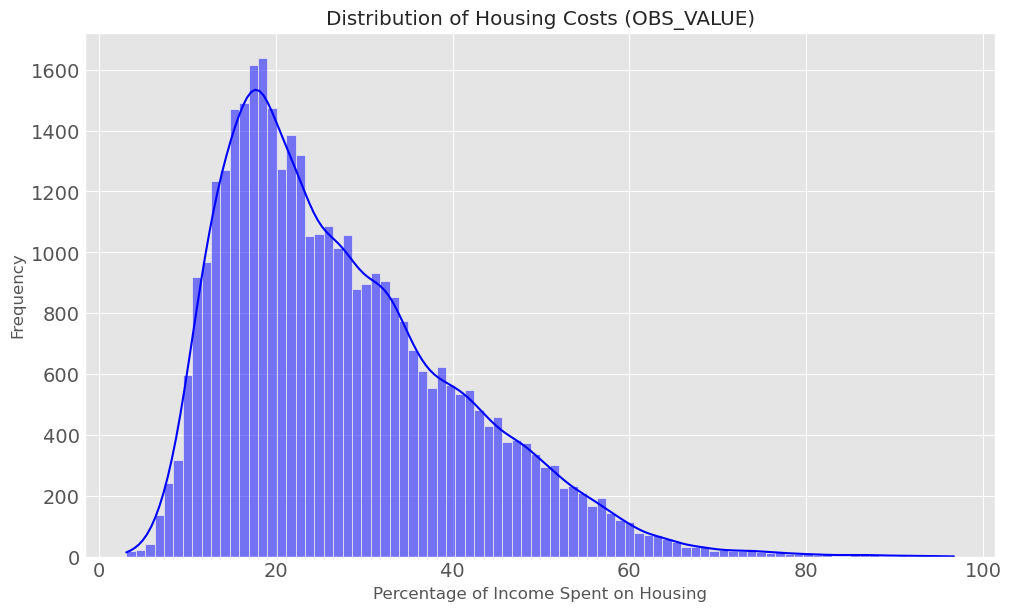

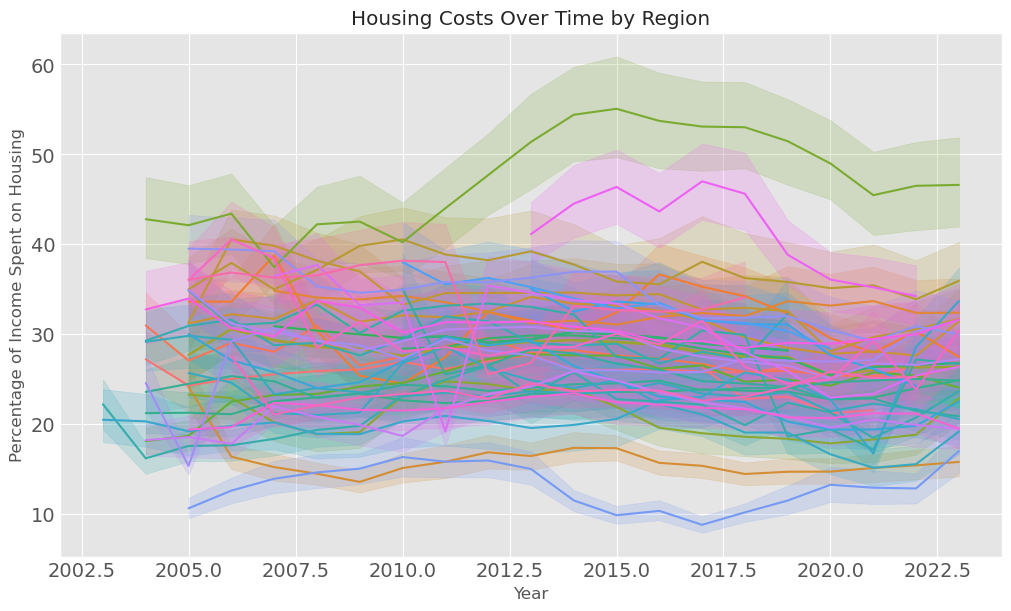

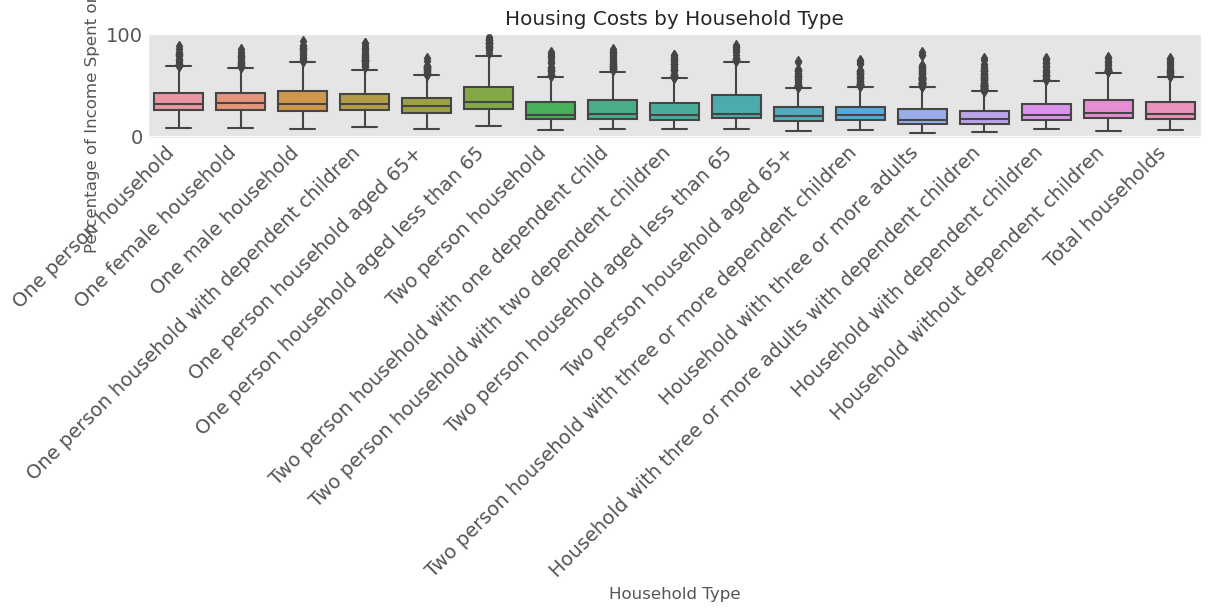

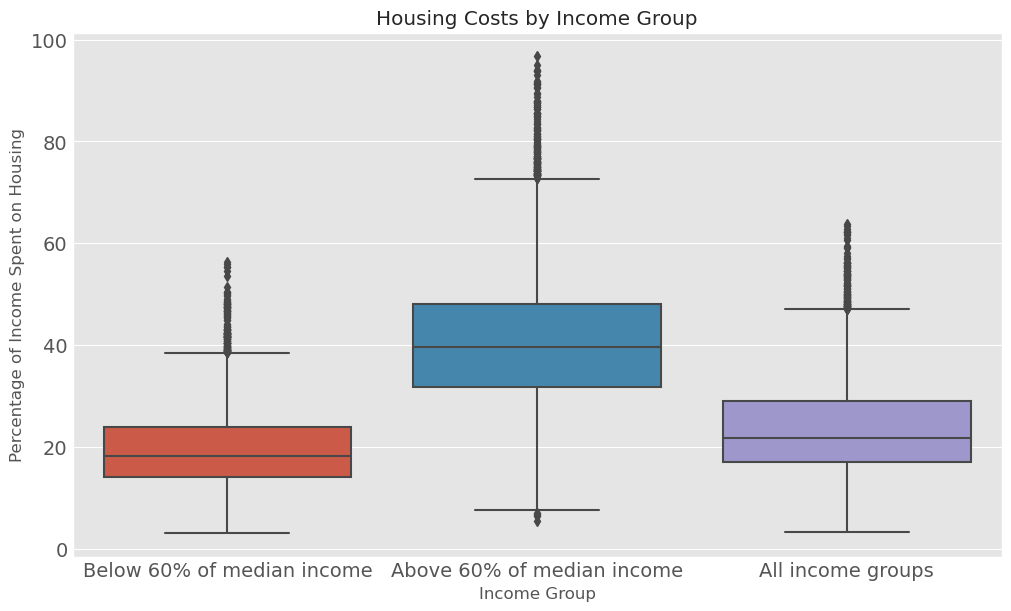

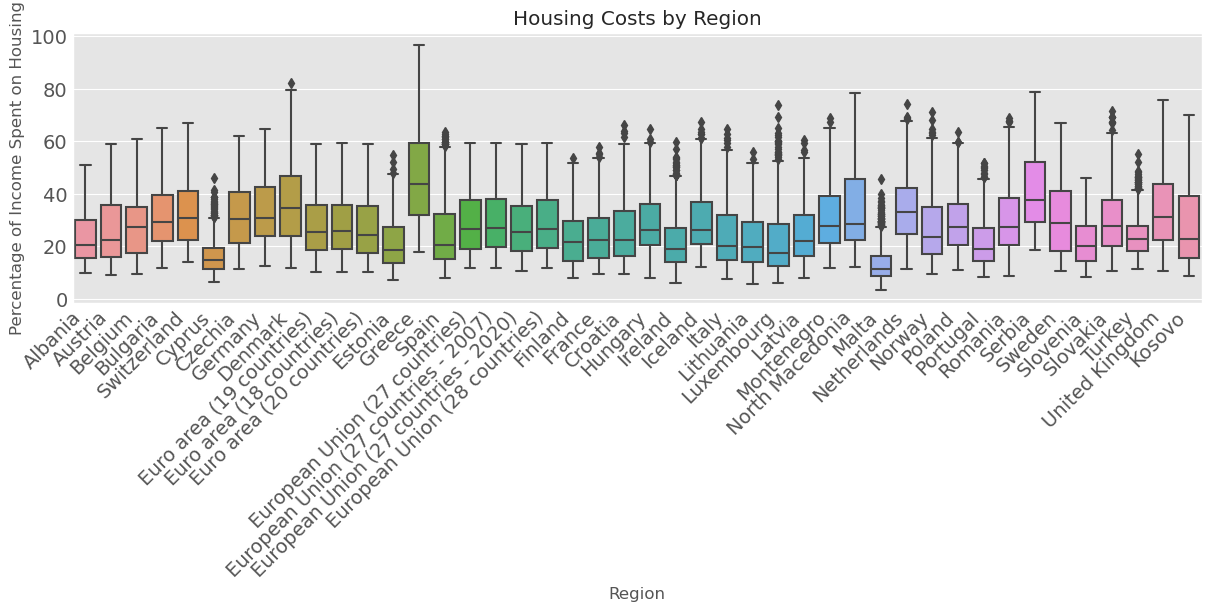

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure style
plt.style.use('ggplot')

# 1. Distribution of Housing Costs (OBS_VALUE)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['OBS_VALUE'], kde=True, color='blue')
plt.title('Distribution of Housing Costs (OBS_VALUE)')
plt.xlabel('Percentage of Income Spent on Housing')
plt.ylabel('Frequency')
plt.show()

# 2. Housing Costs Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_clean, x='TIME_PERIOD', y='OBS_VALUE', hue='geo_encoded', legend=False)
plt.title('Housing Costs Over Time by Region')
plt.xlabel('Year')
plt.ylabel('Percentage of Income Spent on Housing')
plt.show()

# 3. Housing Costs by Household Type
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='hhtyp_encoded', y='OBS_VALUE')
plt.title('Housing Costs by Household Type')
plt.xlabel('Household Type')
plt.ylabel('Percentage of Income Spent on Housing')
plt.xticks(rotation=45, ha="right")
plt.show()

# 4. Housing Costs by Income Group
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='incgrp_encoded', y='OBS_VALUE')
plt.title('Housing Costs by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Percentage of Income Spent on Housing')
plt.show()

# 5. Housing Costs by Region
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='geo_encoded', y='OBS_VALUE')
plt.title('Housing Costs by Region')
plt.xlabel('Region')
plt.ylabel('Percentage of Income Spent on Housing')
plt.xticks(rotation=45, ha="right")
plt.show()


In [ ]:


# Step 1: Convert features and target to numpy arrays for PyMC3
X_data = df_clean[['hhtyp_encoded', 'incgrp_encoded', 'geo_encoded', 'TIME_PERIOD_normalized']].values
y_data = df_clean['OBS_VALUE_normalized'].values

# Step 2: Define the Bayesian regression model
with pm.Model() as model:
    # Priors for the regression coefficients (one for each feature)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coeff_hhtyp = pm.Normal('coeff_hhtyp', mu=0, sigma=10)
    coeff_incgrp = pm.Normal('coeff_incgrp', mu=0, sigma=10)
    coeff_geo = pm.Normal('coeff_geo', mu=0, sigma=10)
    coeff_time = pm.Normal('coeff_time', mu=0, sigma=10)
    
    # Prior for the noise (standard deviation of the error term)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Linear regression equation
    mu = (intercept + 
          coeff_hhtyp * X_data[:, 0] +  # Household type
          coeff_incgrp * X_data[:, 1] +  # Income group
          coeff_geo * X_data[:, 2] +     # Region
          coeff_time * X_data[:, 3])     # Time period (year)
    
    # Likelihood: observed data is normally distributed around mu
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_data)
    
    # Step 3: Sample from the posterior distribution using MCMC
    trace = pm.sample(2000, return_inferencedata=False)

# Step 4: Plot the trace of the posterior distributions
pm.traceplot(trace)
plt.show()

# Step 5: Summarize the posterior distributions
pm.summary(trace)
